# Hospital-onset COVID data - England

This notebook attempts to combine data from [NHS England](https://www.england.nhs.uk/statistics/statistical-work-areas/covid-19-hospital-activity/) and the [ONS COVID-19 survey](https://www.ons.gov.uk/peoplepopulationandcommunity/healthandsocialcare/conditionsanddiseases/datasets/coronaviruscovid19infectionsurveydata) to estimate if nosocomial COVID, as defined by a new COVID-19 diagnosis ≥7d after admission to an NHS hospital, is changing relative to levels of community transmission as measured by the ONS survey.

The ONS survey attempts to estimate the positivity rate of COVID-19 nasal PCRs in the entire private residential population of the UK, both with and without symptoms. This involves repeatedly testing tens of thousands of individuals from households sampled randomly from a large database of addresses. Sample collection was initially facilitated by study worker home visits, which were eventually transitioned to dropoffs and self-collection. Some of the participants also provided blood samples for serologies. Detailed methods are in [this article](https://www.thelancet.com/journals/lanpub/article/PIIS2468-2667(20)30282-6/fulltext).

We use positivity rate in the residential population as a proxy for community transmission rates. (Nosocomial transmission is [expected to correlate with community transmission](https://pubmed.ncbi.nlm.nih.gov/36738991/).) We do this because we are interested in changes surrounding NHS' discontinuation of screening all admissions on [Aug 31 2022](https://www.gov.uk/government/news/regular-asymptomatic-testing-paused-in-additional-settings). On Twitter, it [has been reported](https://twitter.com/AdeleGroyer/status/1605876274337046530) that the proportion of nosocomial cases relative to all inpatient COVID-19 cases has increased since this change (orange line). However, since the denominator of all cases might be expected to shrink under the new testing strategy, we decided to re-normalize the nosocomial case counts against community positivity levels. Serial testing for the ONS survey should not be affected by the new testing strategy in hospitals.

In [1]:
suppressMessages({
    require(plyr)
    require(tidyverse)
    require(data.table)
    require(readxl)
    require(viridis)
    require(ggplot2)
    require(yaml)
    require(cowplot)
    require(lubridate)
})

options(repr.plot.res=224)

Let's pull the NHS data for daily COVID-19 admissions in England

In [2]:
weekly_covid_adm_path <- 'data/NHS-weekly-admissions/'
weekly_covid_adm_spec <- '
-
    file: Weekly-covid-admissions-and-beds-publication-210429-up-to-210406-DQnotes.xlsx
    total_covid_admits:
        sheet: 2
        dates: E15:IS15
        values: E16:IS16
    community_onset_covid_admits:
        sheet: 4
        dates: E15:IS15
        values: E16:IS16
-
    file: Weekly-covid-admissions-and-beds-publication-211209-210407-210930-DQnotes.xlsx
    total_covid_admits:
        sheet: 2
        dates: E15:FY15
        values: E16:FY16
    community_onset_covid_admits:
        sheet: 4
        dates: E15:FY15
        values: E16:FY16
-
    file: Weekly-covid-admissions-and-beds-publication-220512_211001to220331-1.xlsx
    total_covid_admits:
        sheet: 2
        dates: E15:GD15
        values: E16:GD16
    community_onset_covid_admits:
        sheet: 4
        dates: E15:GD15
        values: E16:GD16
- 
    file: Weekly-covid-admissions-and-beds-publication-221124_220401to220930.xlsx
    total_covid_admits:
        sheet: 2
        dates: C13:GC13
        values: C14:GC14
    community_onset_covid_admits:
        sheet: 2
        dates: C43:GC43
        values: C44:GC44
- 
    file: Weekly-covid-admissions-and-beds-publication-221229.xlsx
    total_covid_admits:
        sheet: 1
        dates: C13:CK13
        values: C14:CK14
    community_onset_covid_admits:
        sheet: 1
        dates: C28:CK28
        values: C29:CK29
'
weekly_covid_adm_spec <- yaml.load(weekly_covid_adm_spec)
tail(weekly_covid_adm_spec, n=2)

[[1]]
[[1]]$file
[1] "Weekly-covid-admissions-and-beds-publication-221124_220401to220930.xlsx"

[[1]]$total_covid_admits
[[1]]$total_covid_admits$sheet
[1] 2

[[1]]$total_covid_admits$dates
[1] "C13:GC13"

[[1]]$total_covid_admits$values
[1] "C14:GC14"


[[1]]$community_onset_covid_admits
[[1]]$community_onset_covid_admits$sheet
[1] 2

[[1]]$community_onset_covid_admits$dates
[1] "C43:GC43"

[[1]]$community_onset_covid_admits$values
[1] "C44:GC44"



[[2]]
[[2]]$file
[1] "Weekly-covid-admissions-and-beds-publication-221229.xlsx"

[[2]]$total_covid_admits
[[2]]$total_covid_admits$sheet
[1] 1

[[2]]$total_covid_admits$dates
[1] "C13:CK13"

[[2]]$total_covid_admits$values
[1] "C14:CK14"


[[2]]$community_onset_covid_admits
[[2]]$community_onset_covid_admits$sheet
[1] 1

[[2]]$community_onset_covid_admits$dates
[1] "C28:CK28"

[[2]]$community_onset_covid_admits$values
[1] "C29:CK29"

In [3]:
dts <- llply(weekly_covid_adm_spec, function(file_spec) {
    path.xl <- paste0(weekly_covid_adm_path, file_spec$file)
    # suppressMessages used because of https://github.com/tidyverse/readxl/issues/580
    total_covid_adm_count <- as.numeric(suppressMessages(read_excel(path.xl,
        sheet = file_spec$total_covid_admits$sheet, 
        range = file_spec$total_covid_admits$values, col_names = FALSE)))
    community_onset_adm_count <- as.numeric(suppressMessages(read_excel(path.xl, 
        sheet = file_spec$community_onset_covid_admits$sheet, 
        range = file_spec$community_onset_covid_admits$values, col_names = FALSE)))
    date <- suppressMessages(as.Date(t(read_excel(path.xl, 
        sheet = file_spec$community_onset_covid_admits$sheet, 
        range = file_spec$community_onset_covid_admits$dates, col_names = FALSE))[,1]))
    data.table(date, total_covid_adm_count, community_onset_adm_count)
})

dt.covid_admits_daily <- rbindlist(dts)
setkey(dt.covid_admits_daily, "date")
head(dt.covid_admits_daily)
tail(dt.covid_admits_daily)

date,total_covid_adm_count,community_onset_adm_count
<date>,<dbl>,<dbl>
2020-08-01,50,30
2020-08-02,57,37
2020-08-03,74,50
2020-08-04,58,36
2020-08-05,60,48
2020-08-06,52,41


date,total_covid_adm_count,community_onset_adm_count
<date>,<dbl>,<dbl>
2022-12-21,1293,863
2022-12-22,1236,873
2022-12-23,899,696
2022-12-24,780,613
2022-12-25,844,645
2022-12-26,988,701


Most of the other data we will use is tallied weekly instead of daily, so let's convert the above into weekly tallies

It doesn't particularly matter which day of the week each week ends on, because the ONS survey are not consistent about this. Therefore, when we join things together, we'll use a [rolling join to the nearest value](https://atrebas.github.io/post/2019-03-03-datatable-dplyr/#rolling-joinssubsets-performed-on-the-last-numeric-column).

We drop the last row of data because it includes an incomplete week.

- Furthermore, as seen below, there are weeks with no good overlap with ONS data. In later versions of the ONS data for England, we found that this month has a gap from Dec 9 to Dec 22 (perhaps due to a period with low testing collection or processing related to winter holidays).

- Therefore, we ended the analytical period on Dec 16 to avoid normalizing weekly counts to ONS data more than 7d away, which would be incongruous.

In [4]:
dt.covid_admits_weekly <- dt.covid_admits_daily[
    ,
    .(
        community_onset_adm_count = sum(community_onset_adm_count),
        total_covid_adm_count = sum(total_covid_adm_count)
    ),
    keyby = .(week_ending_date = 7 * as.numeric(date - min(date)) %/% 7 + 6 + min(date))
]
dt.covid_admits_weekly <- head(dt.covid_admits_weekly, -1)
fwrite(dt.covid_admits_weekly, file = 'data/NHS-weekly-admissions/weekly_covid_admissions.csv')
head(dt.covid_admits_weekly)
tail(dt.covid_admits_weekly)

week_ending_date,community_onset_adm_count,total_covid_adm_count
<date>,<dbl>,<dbl>
2020-08-07,285,411
2020-08-14,297,410
2020-08-21,247,331
2020-08-28,253,335
2020-09-04,319,415
2020-09-11,587,776


week_ending_date,community_onset_adm_count,total_covid_adm_count
<date>,<dbl>,<dbl>
2022-11-18,2390,3326
2022-11-25,2385,3380
2022-12-02,2625,3936
2022-12-09,2955,4642
2022-12-16,3923,6306
2022-12-23,5249,8075


Next, the ONS survey data for estimated COVID-19 positivity, plucking out the columns for England specifically

In [5]:
path.xl <- 'data/ONS-covid19-survey/20221223covid19infectionsurveydatasetsengland22122022142715.xlsx'
ons_col_names <- c("date_range", 
        "est_pct_positive", "est_pct_positive_ci95_lo", "est_pct_positive_ci95_hi",
        "est_pop_positive", "est_pop_positive_ci95_lo", "est_pop_positive_ci95_hi",
        "est_ratio_positive", "est_ratio_positive_ci95_lo", "est_ratio_positive_ci95_hi")
suppressMessages({
    dt.covid_survey <- as.data.table(read_excel(path.xl, sheet = 7, range = "A18:J142", col_names = ons_col_names))
})
dt.covid_survey[
    ,
    ':='(
       date_lo = dmy(str_split_fixed(date_range, " to ", 2)[, 1]),
       date_hi = dmy(str_split_fixed(date_range, " to ", 2)[, 2]),
       # This is the date column we will do the rolling join on (== date_hi)
       # We don't simply use date_hi, so we can preserve the original value of date_hi before the rolling join
       date = dmy(str_split_fixed(date_range, " to ", 2)[, 2]) 
    )
]
last_ons_date <- max(dt.covid_survey$date_hi)
head(dt.covid_survey)
tail(dt.covid_survey)
last_ons_date

date_range,est_pct_positive,est_pct_positive_ci95_lo,est_pct_positive_ci95_hi,est_pop_positive,est_pop_positive_ci95_lo,est_pop_positive_ci95_hi,est_ratio_positive,est_ratio_positive_ci95_lo,est_ratio_positive_ci95_hi,date_lo,date_hi,date
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<date>,<date>,<date>
27 July 2020 to 02 August 2020,0.05,0.03,0.07,28300,18900,40800,"1 in 2,000","1 in 3,300","1 in 1,400",2020-07-27,2020-08-02,2020-08-02
03 August 2020 to 09 August 2020,0.05,0.03,0.07,28300,19000,40700,"1 in 2,000","1 in 3,300","1 in 1,400",2020-08-03,2020-08-09,2020-08-09
07 August 2020 to 13 August 2020,0.05,0.03,0.06,24600,16900,33800,"1 in 2,200","1 in 3,400","1 in 1,600",2020-08-07,2020-08-13,2020-08-13
14 August 2020 to 20 August 2020,0.05,0.04,0.07,28200,20100,37900,"1 in 1,900","1 in 2,800","1 in 1,300",2020-08-14,2020-08-20,2020-08-20
19 August 2020 to 25 August 2020,0.05,0.04,0.07,27100,19300,36700,"1 in 2,000","1 in 2,800","1 in 1,500",2020-08-19,2020-08-25,2020-08-25
30 August 2020 to 05 September 2020,0.07,0.05,0.10,39700,29300,52700,"1 in 1,400","1 in 1,900","1 in 1,000",2020-08-30,2020-09-05,2020-09-05


date_range,est_pct_positive,est_pct_positive_ci95_lo,est_pct_positive_ci95_hi,est_pop_positive,est_pop_positive_ci95_lo,est_pop_positive_ci95_hi,est_ratio_positive,est_ratio_positive_ci95_lo,est_ratio_positive_ci95_hi,date_lo,date_hi,date
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<date>,<date>,<date>
02 November 2022 to 08 November 2022,1.73,1.63,1.82,940700,888600,994200,1 in 60,1 in 60,1 in 55,2022-11-02,2022-11-08,2022-11-08
09 November 2022 to 15 November 2022,1.48,1.39,1.58,809200,757900,862600,1 in 65,1 in 70,1 in 65,2022-11-09,2022-11-15,2022-11-15
15 November 2022 to 21 November 2022,1.60,1.50,1.70,873200,818600,928300,1 in 60,1 in 65,1 in 60,2022-11-15,2022-11-21,2022-11-21
20 November 2022 to 26 November 2022,1.73,1.60,1.86,941700,874100,1013600,1 in 60,1 in 60,1 in 55,2022-11-20,2022-11-26,2022-11-26
29 November 2022 to 05 December 2022,2.01,1.87,2.15,1095100,1022000,1173500,1 in 50,1 in 55,1 in 45,2022-11-29,2022-12-05,2022-12-05
03 December 2022 to 09 December 2022,2.20,2.08,2.32,1197200,1135000,1263900,1 in 45,1 in 50,1 in 45,2022-12-03,2022-12-09,2022-12-09


[1] "2022-12-09"

In [6]:
dt.joined <- dt.covid_survey[dt.covid_admits_weekly, on = .(date == week_ending_date), roll = "nearest"]
dt.joined[, hospital_onset_adm_count := total_covid_adm_count - community_onset_adm_count]
dt.joined[, hospital_onset_ratio := hospital_onset_adm_count / total_covid_adm_count]
dt.joined[, hospital_onset_vs_comm_ratio := hospital_onset_adm_count / community_onset_adm_count]
dt.joined[, hospital_onset_vs_comm_positivity := hospital_onset_adm_count / est_pct_positive]
dt.joined[, hospital_onset_vs_comm_positives := hospital_onset_adm_count / est_pop_positive]
dt.joined[, hospital_onset_vs_comm_positives_ci95_hi := hospital_onset_adm_count / est_pop_positive_ci95_lo]
dt.joined[, hospital_onset_vs_comm_positives_ci95_lo := hospital_onset_adm_count / est_pop_positive_ci95_hi]

After December 9, there are no more ONS data for England. We don't want to keep joining future admissions data (beyond ~7d or so) to the last row of ONS data, so best to just drop them.

In [7]:
dt.joined <- dt.joined[date <= last_ons_date + 7, ]
head(dt.joined)
tail(dt.joined[, .(date_range, date)])

date_range,est_pct_positive,est_pct_positive_ci95_lo,est_pct_positive_ci95_hi,est_pop_positive,est_pop_positive_ci95_lo,est_pop_positive_ci95_hi,est_ratio_positive,est_ratio_positive_ci95_lo,est_ratio_positive_ci95_hi,⋯,date,community_onset_adm_count,total_covid_adm_count,hospital_onset_adm_count,hospital_onset_ratio,hospital_onset_vs_comm_ratio,hospital_onset_vs_comm_positivity,hospital_onset_vs_comm_positives,hospital_onset_vs_comm_positives_ci95_hi,hospital_onset_vs_comm_positives_ci95_lo
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,⋯,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
03 August 2020 to 09 August 2020,0.05,0.03,0.07,28300,19000,40700,"1 in 2,000","1 in 3,300","1 in 1,400",⋯,2020-08-07,285,411,126,0.3065693,0.4421053,2520.000,0.004452297,0.006631579,0.003095823
07 August 2020 to 13 August 2020,0.05,0.03,0.06,24600,16900,33800,"1 in 2,200","1 in 3,400","1 in 1,600",⋯,2020-08-14,297,410,113,0.2756098,0.3804714,2260.000,0.004593496,0.006686391,0.003343195
14 August 2020 to 20 August 2020,0.05,0.04,0.07,28200,20100,37900,"1 in 1,900","1 in 2,800","1 in 1,300",⋯,2020-08-21,247,331,84,0.2537764,0.3400810,1680.000,0.002978723,0.004179104,0.002216359
19 August 2020 to 25 August 2020,0.05,0.04,0.07,27100,19300,36700,"1 in 2,000","1 in 2,800","1 in 1,500",⋯,2020-08-28,253,335,82,0.2447761,0.3241107,1640.000,0.003025830,0.004248705,0.002234332
30 August 2020 to 05 September 2020,0.07,0.05,0.10,39700,29300,52700,"1 in 1,400","1 in 1,900","1 in 1,000",⋯,2020-09-04,319,415,96,0.2313253,0.3009404,1371.429,0.002418136,0.003276451,0.001821632
04 September 2020 to 10 September 2020,0.11,0.09,0.14,59800,46900,75200,1 in 910,"1 in 1,200",1 in 730,⋯,2020-09-11,587,776,189,0.2435567,0.3219761,1718.182,0.003160535,0.004029851,0.002513298


date_range,date
<chr>,<date>
02 November 2022 to 08 November 2022,2022-11-11
09 November 2022 to 15 November 2022,2022-11-18
20 November 2022 to 26 November 2022,2022-11-25
29 November 2022 to 05 December 2022,2022-12-02
03 December 2022 to 09 December 2022,2022-12-09
03 December 2022 to 09 December 2022,2022-12-16


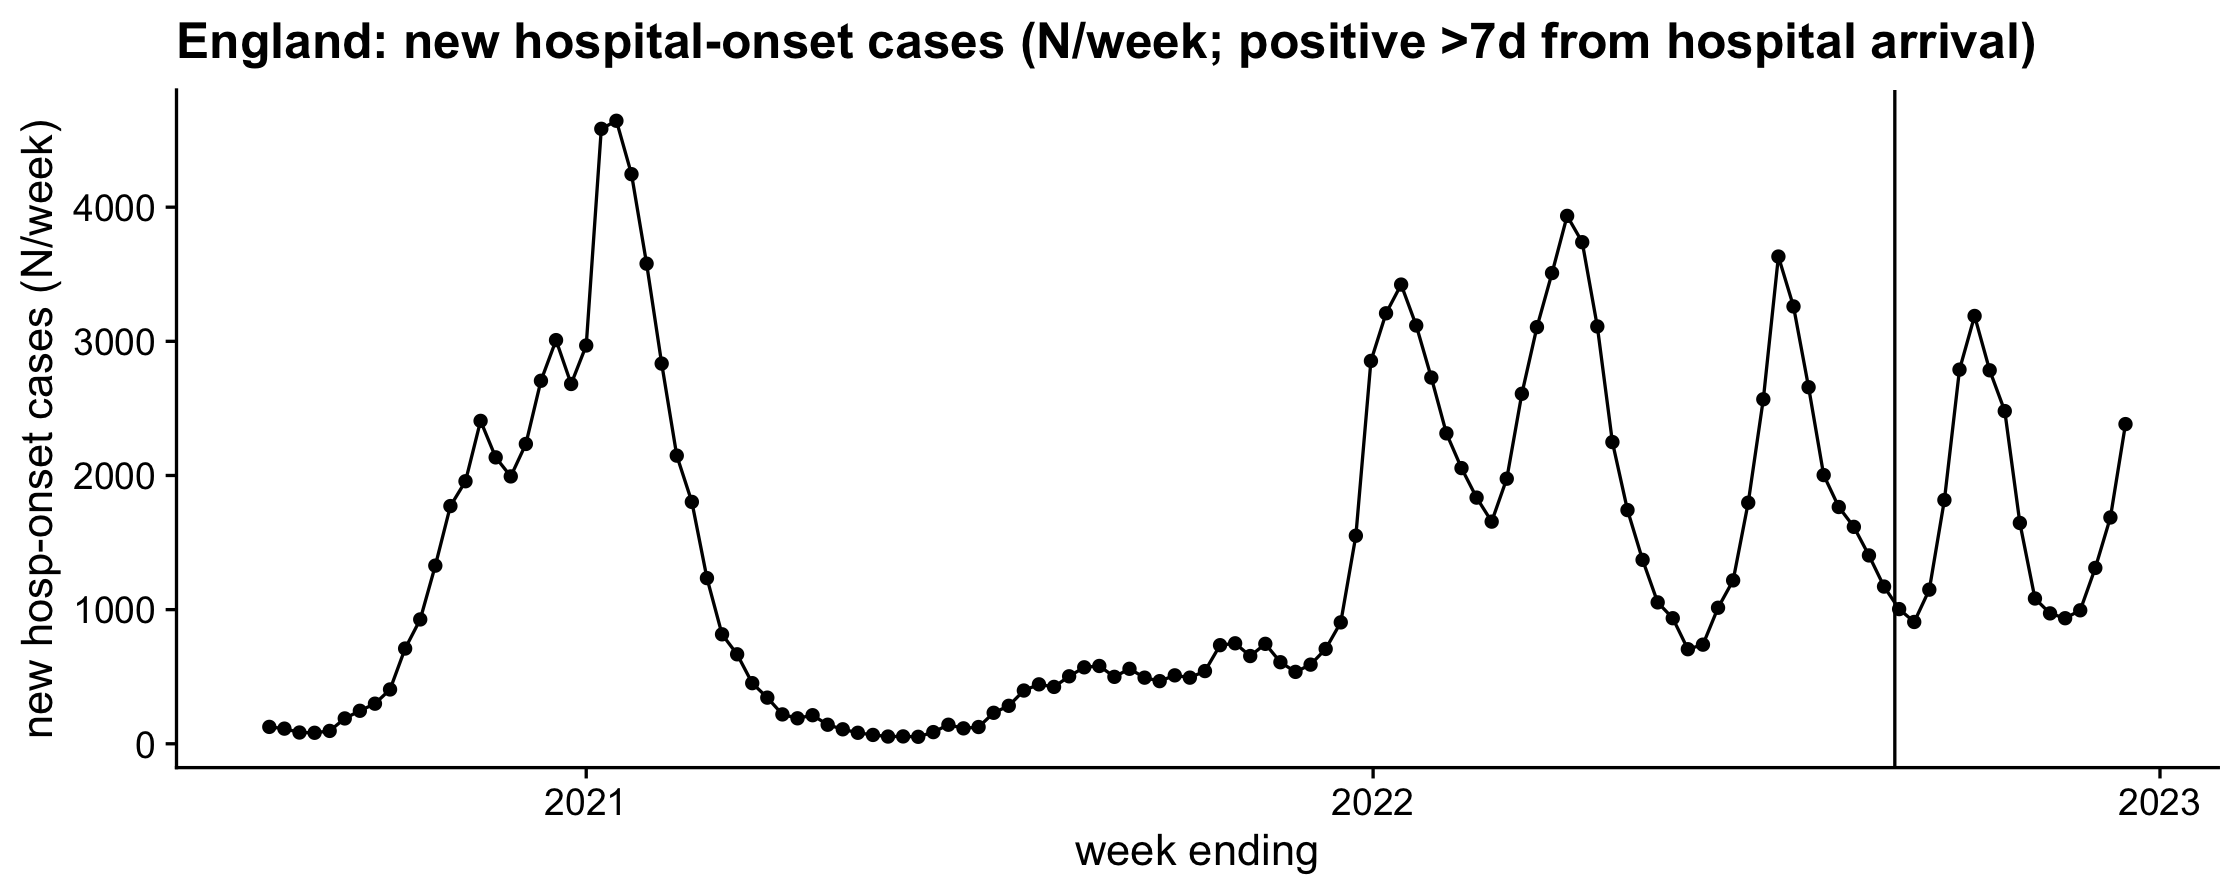

In [8]:
options(repr.plot.width=10, repr.plot.height=4)
ggplot(dt.joined, aes(x=date, y=hospital_onset_adm_count)) +
    geom_line() + geom_point() +
    geom_vline(xintercept = as.Date("2022-08-31"), linetype = "solid") +
    ylab("new hosp-onset cases (N/week)") + xlab("week ending") +
    ggtitle("England: new hospital-onset cases (N/week; positive >7d from hospital arrival)") + 
    theme_cowplot()

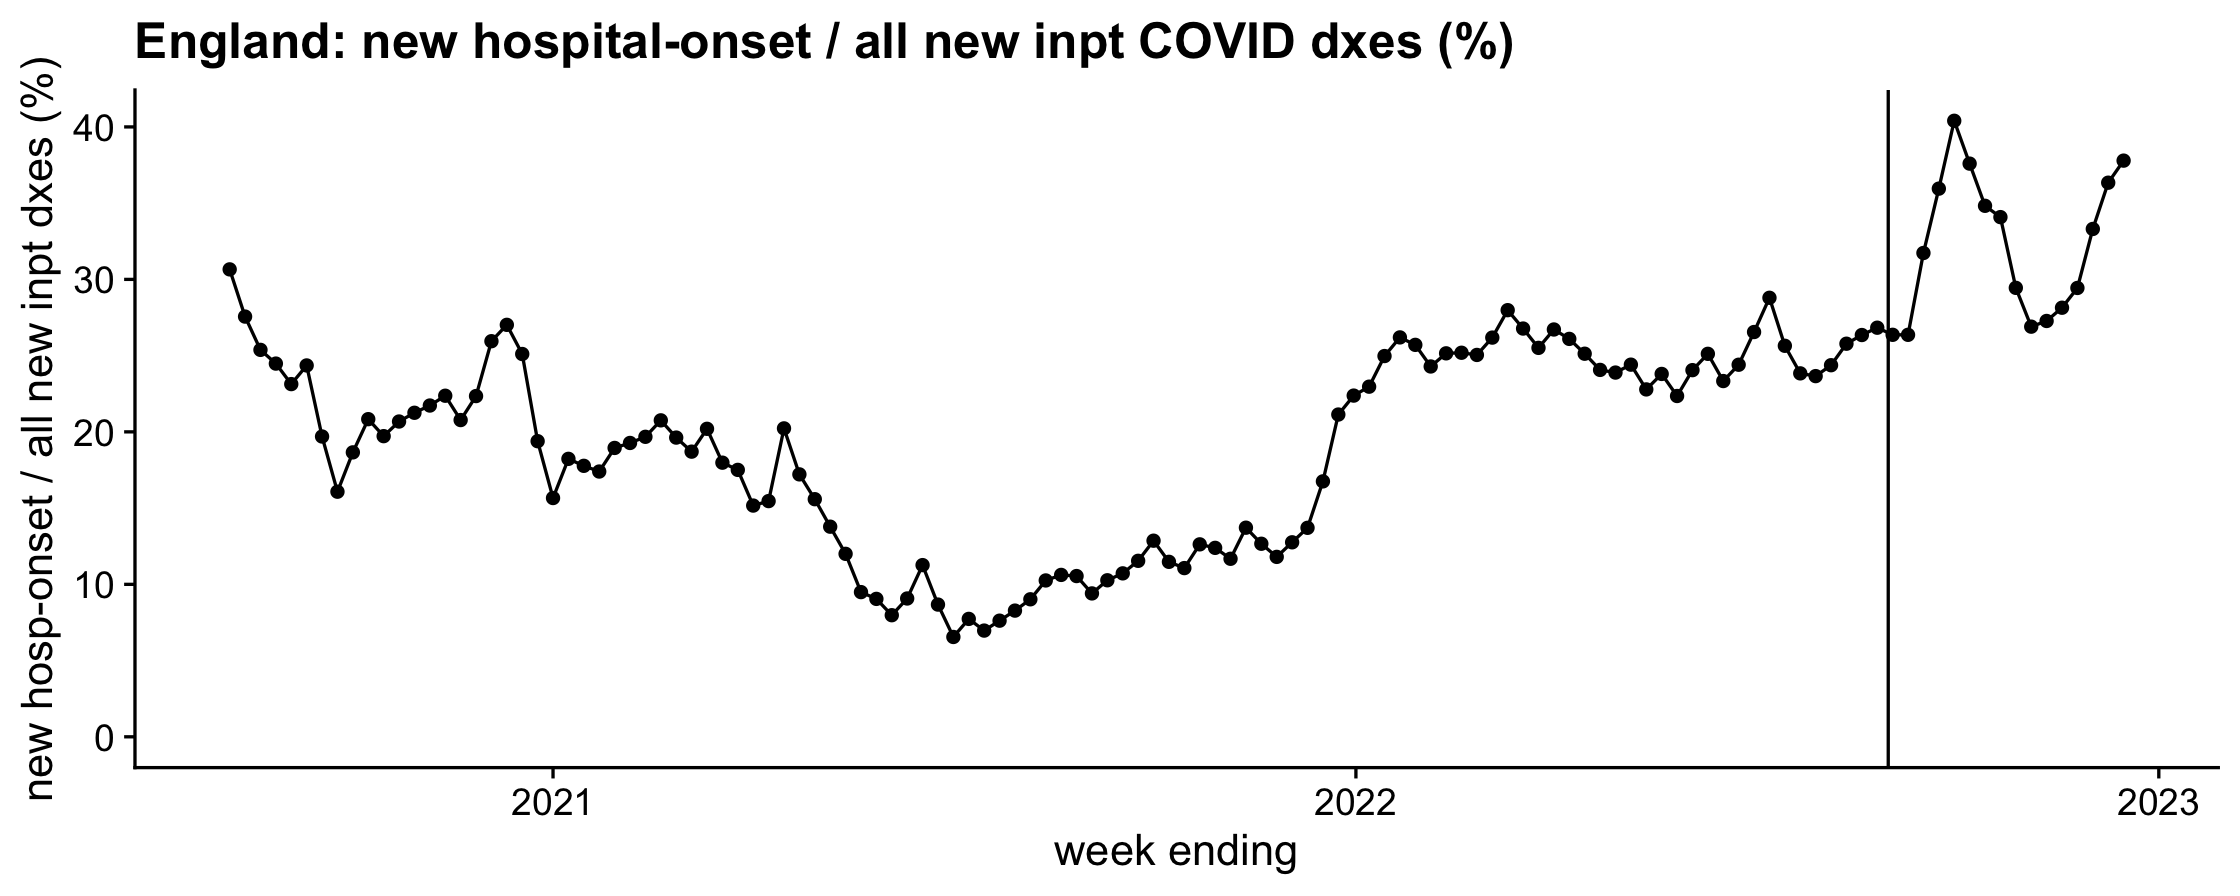

In [9]:
options(repr.plot.width=10, repr.plot.height=4)
ggplot(dt.joined, aes(x=date, y=hospital_onset_ratio * 100)) +
    geom_line() + geom_point() +
    geom_vline(xintercept = as.Date("2022-08-31"), linetype = "solid") +
    ylim(c(0, NA)) + 
    ylab("new hosp-onset / all new inpt dxes (%)") + xlab("week ending") +
    ggtitle("England: new hospital-onset / all new inpt COVID dxes (%)") + 
    theme_cowplot()

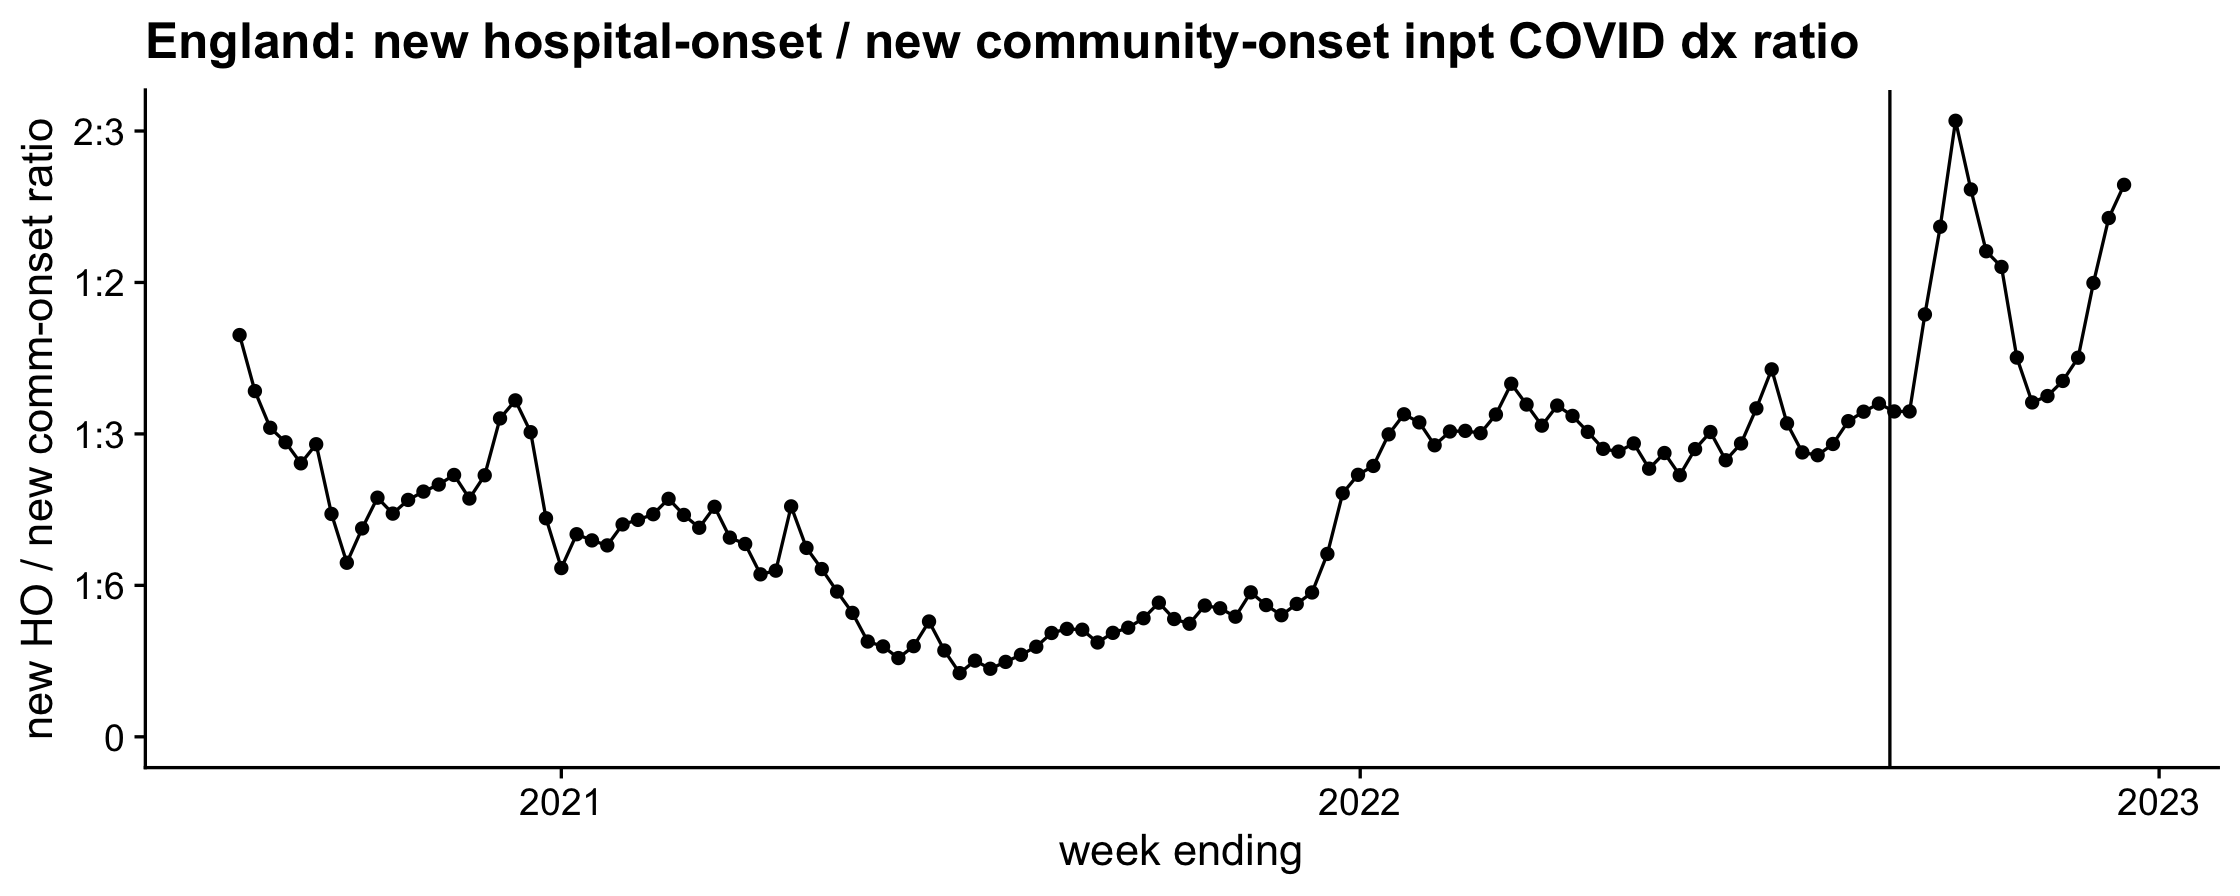

In [10]:
options(repr.plot.width=10, repr.plot.height=4)
ggplot(dt.joined, aes(x=date, y=hospital_onset_vs_comm_ratio)) +
    geom_line() + geom_point() +
    geom_vline(xintercept = as.Date("2022-08-31"), linetype = "solid") +
    scale_y_continuous(lim = c(0, NA), breaks = seq(0, 2/3, 1/6), labels = c("0", "1:6", "1:3", "1:2", "2:3")) +
    ylab("new HO / new comm-onset ratio") + xlab("week ending") +
    ggtitle("England: new hospital-onset / new community-onset inpt COVID dx ratio") + 
    theme_cowplot()

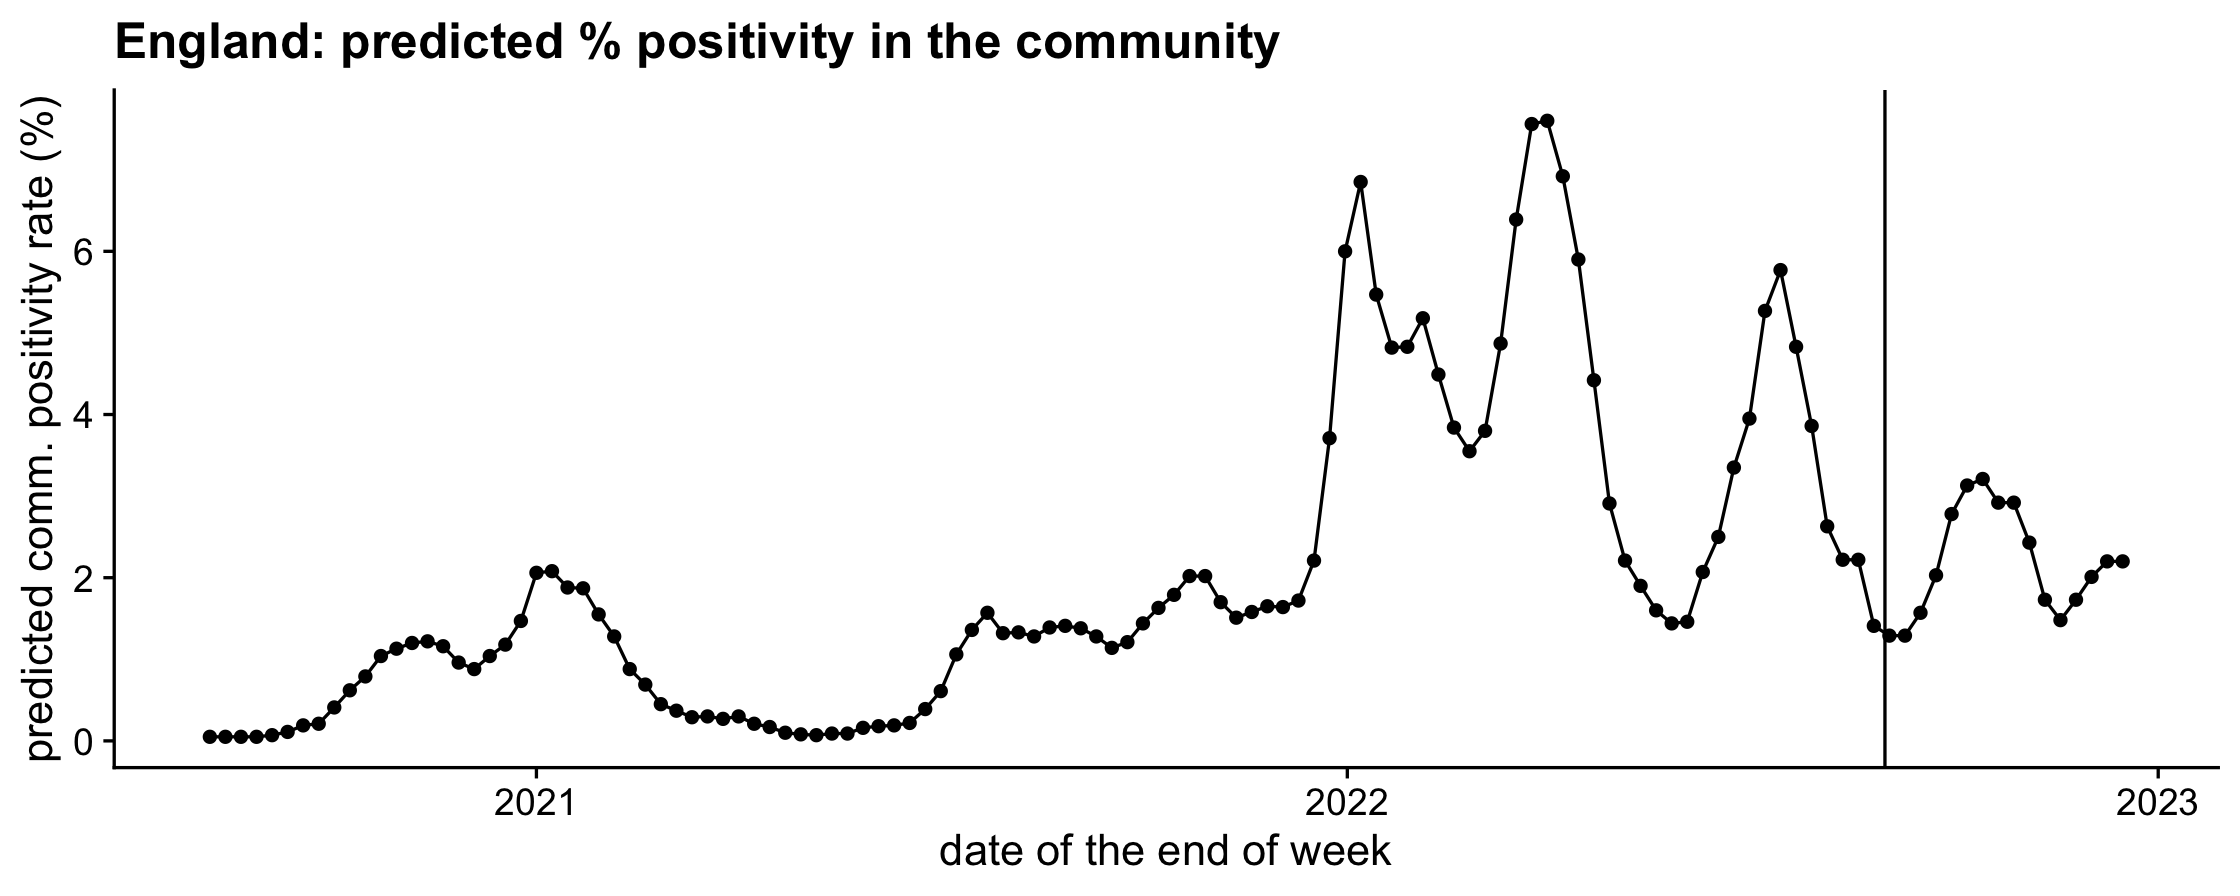

In [11]:
options(repr.plot.width=10, repr.plot.height=4)
ggplot(dt.joined, aes(x=date, y=est_pct_positive)) +
    geom_line() + geom_point() +
    geom_vline(xintercept = as.Date("2022-08-31"), linetype = "solid") +
    ylab("predicted comm. positivity rate (%)") + xlab("date of the end of week") +
    ggtitle("England: predicted % positivity in the community") + 
    theme_cowplot()

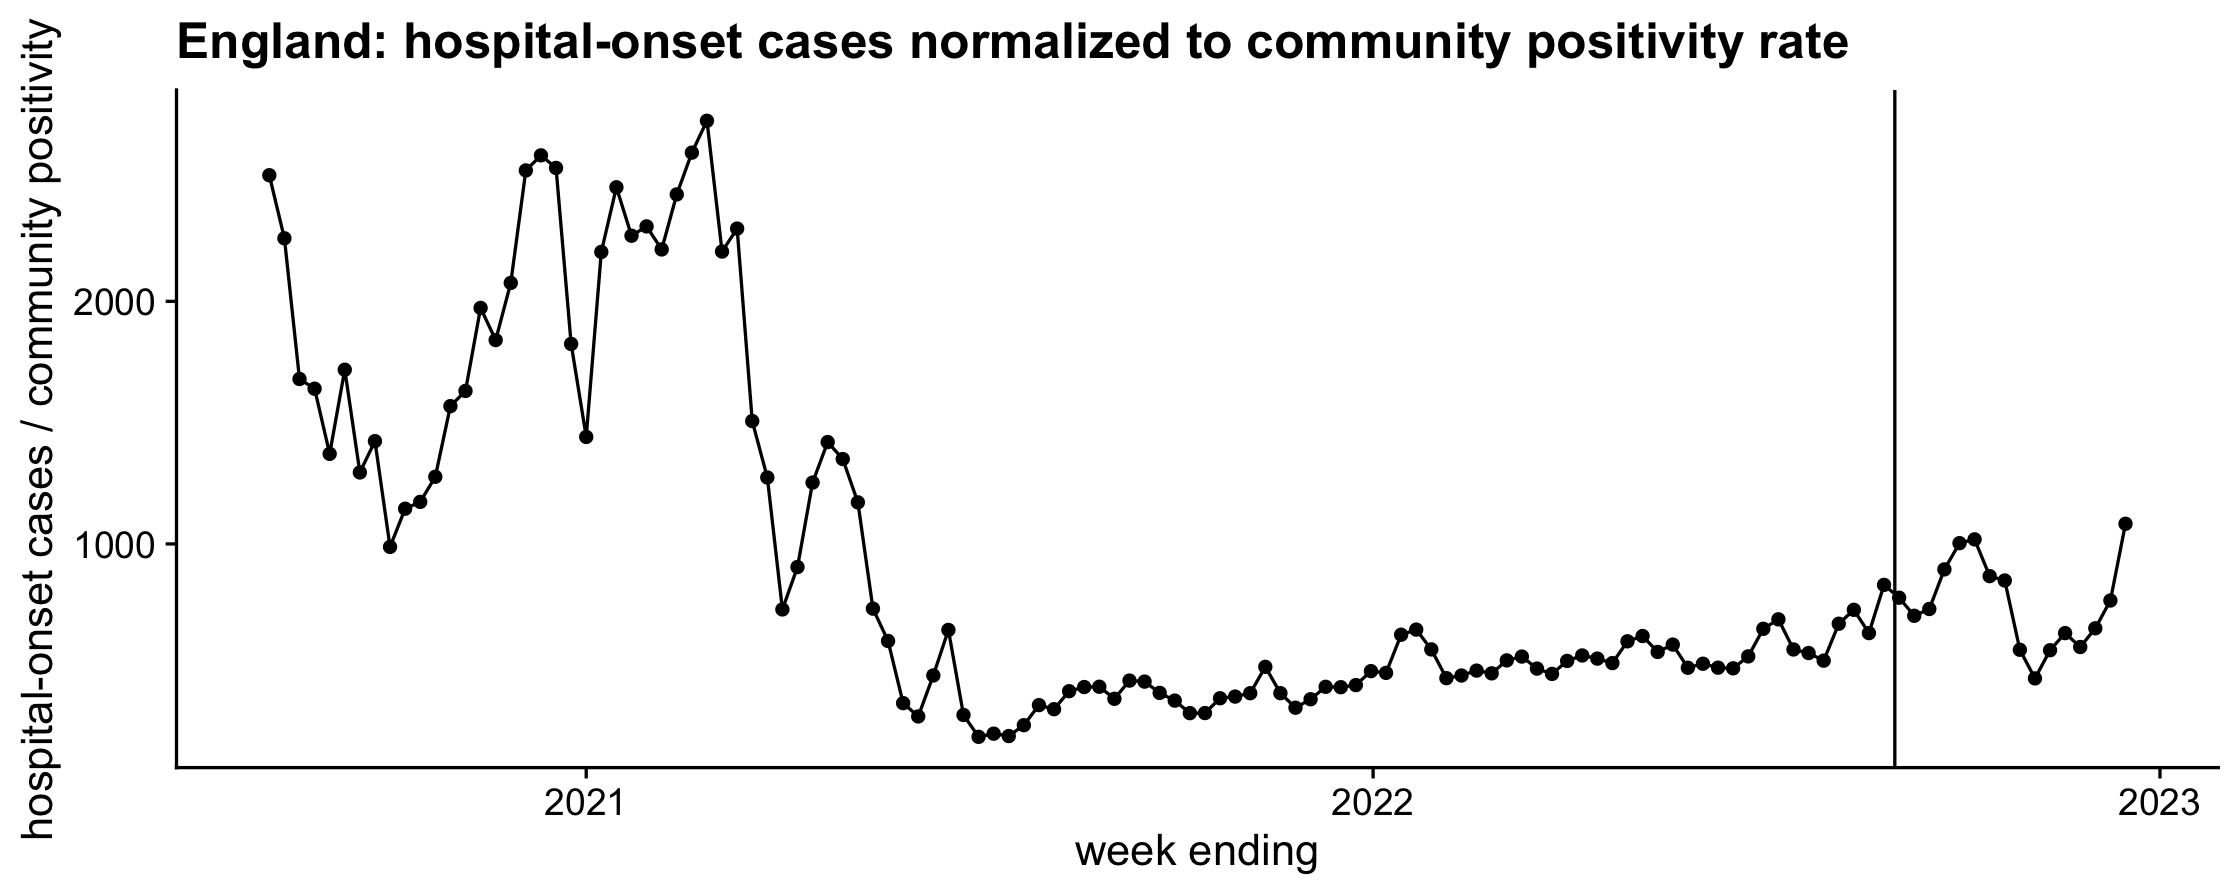

In [12]:
options(repr.plot.width=10, repr.plot.height=4)
ggplot(dt.joined, aes(x=date, y=hospital_onset_vs_comm_positivity)) +
    geom_line() + geom_point() +
    geom_vline(xintercept = as.Date("2022-08-31"), linetype = "solid") +
    ylab("hospital-onset cases / community positivity") + xlab("week ending") +
    ggtitle("England: hospital-onset cases normalized to community positivity rate") + 
    theme_cowplot()

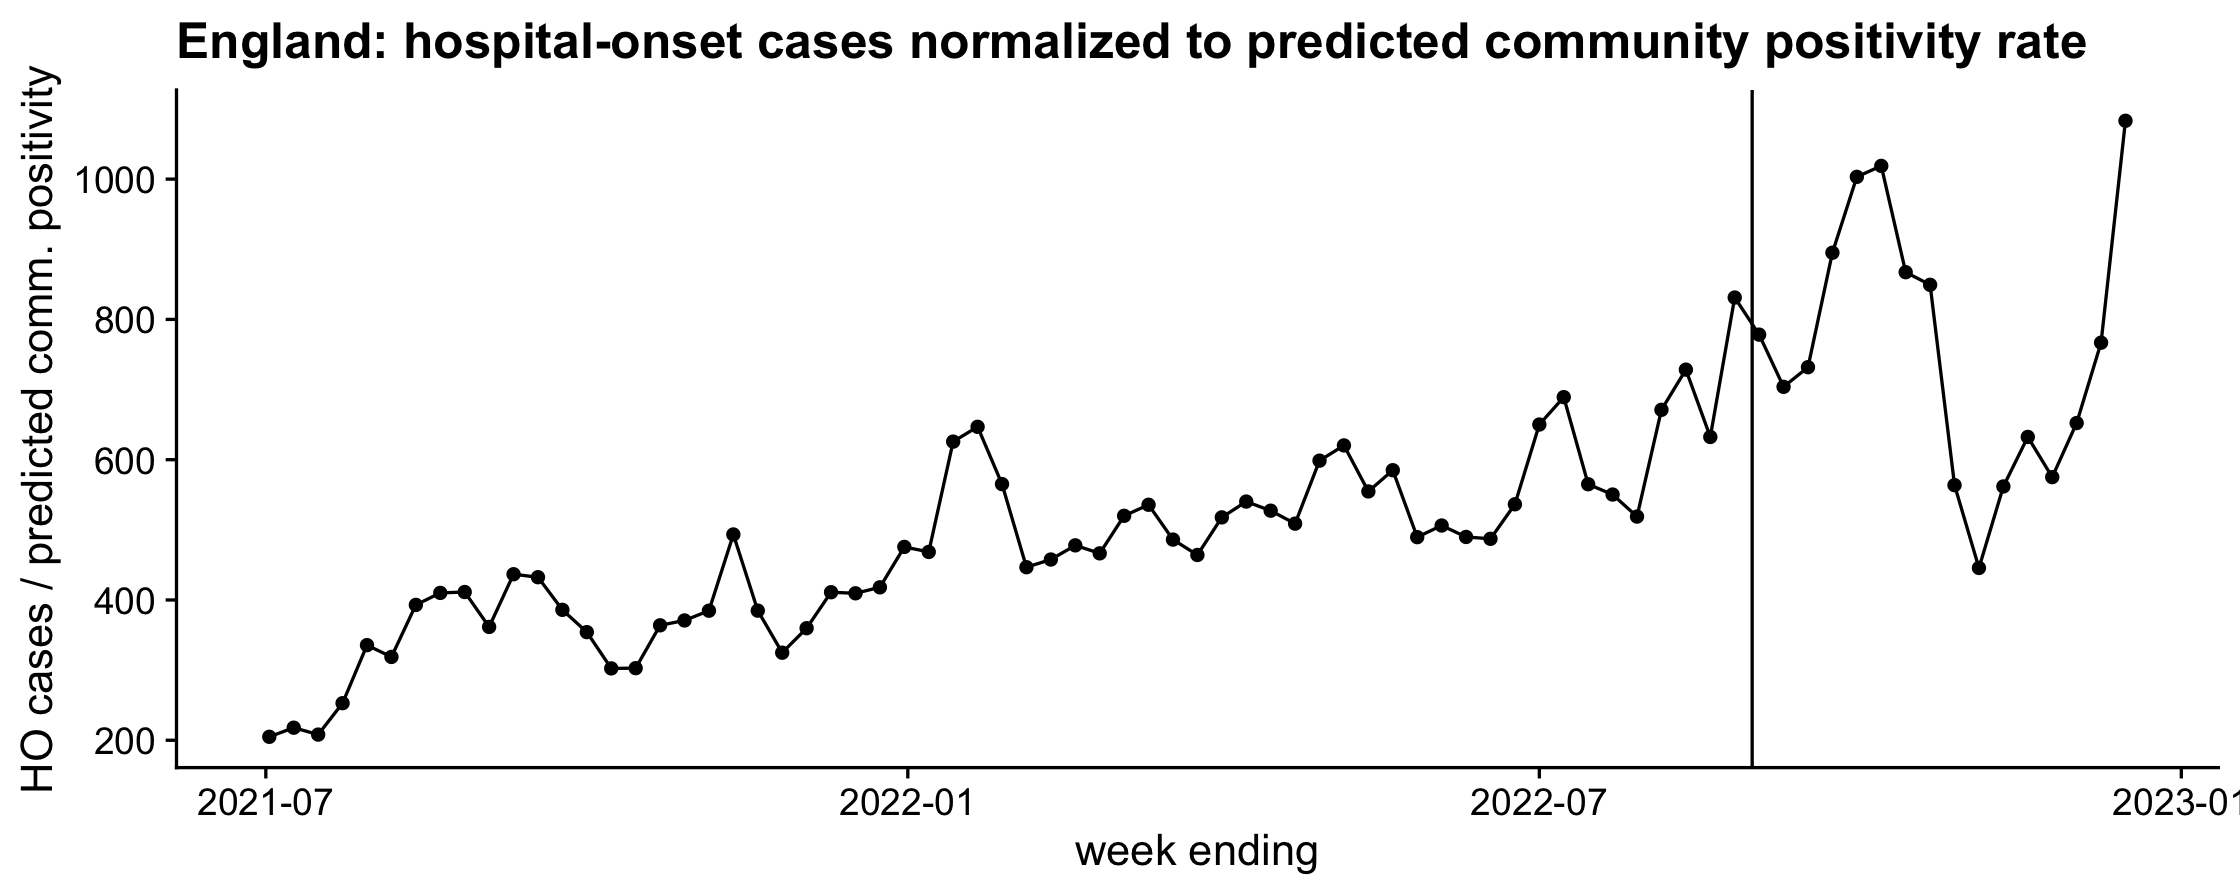

In [13]:
options(repr.plot.width=10, repr.plot.height=4)
ggplot(dt.joined[date >= as.Date('2021-07-01'), ], aes(x=date, y=hospital_onset_vs_comm_positivity)) +
    geom_line() + geom_point() +
    geom_vline(xintercept = as.Date("2022-08-31"), linetype = "solid") +
    ylab("HO cases / predicted comm. positivity") + xlab("week ending") +
    ggtitle("England: hospital-onset cases normalized to predicted community positivity rate") + 
    theme_cowplot()

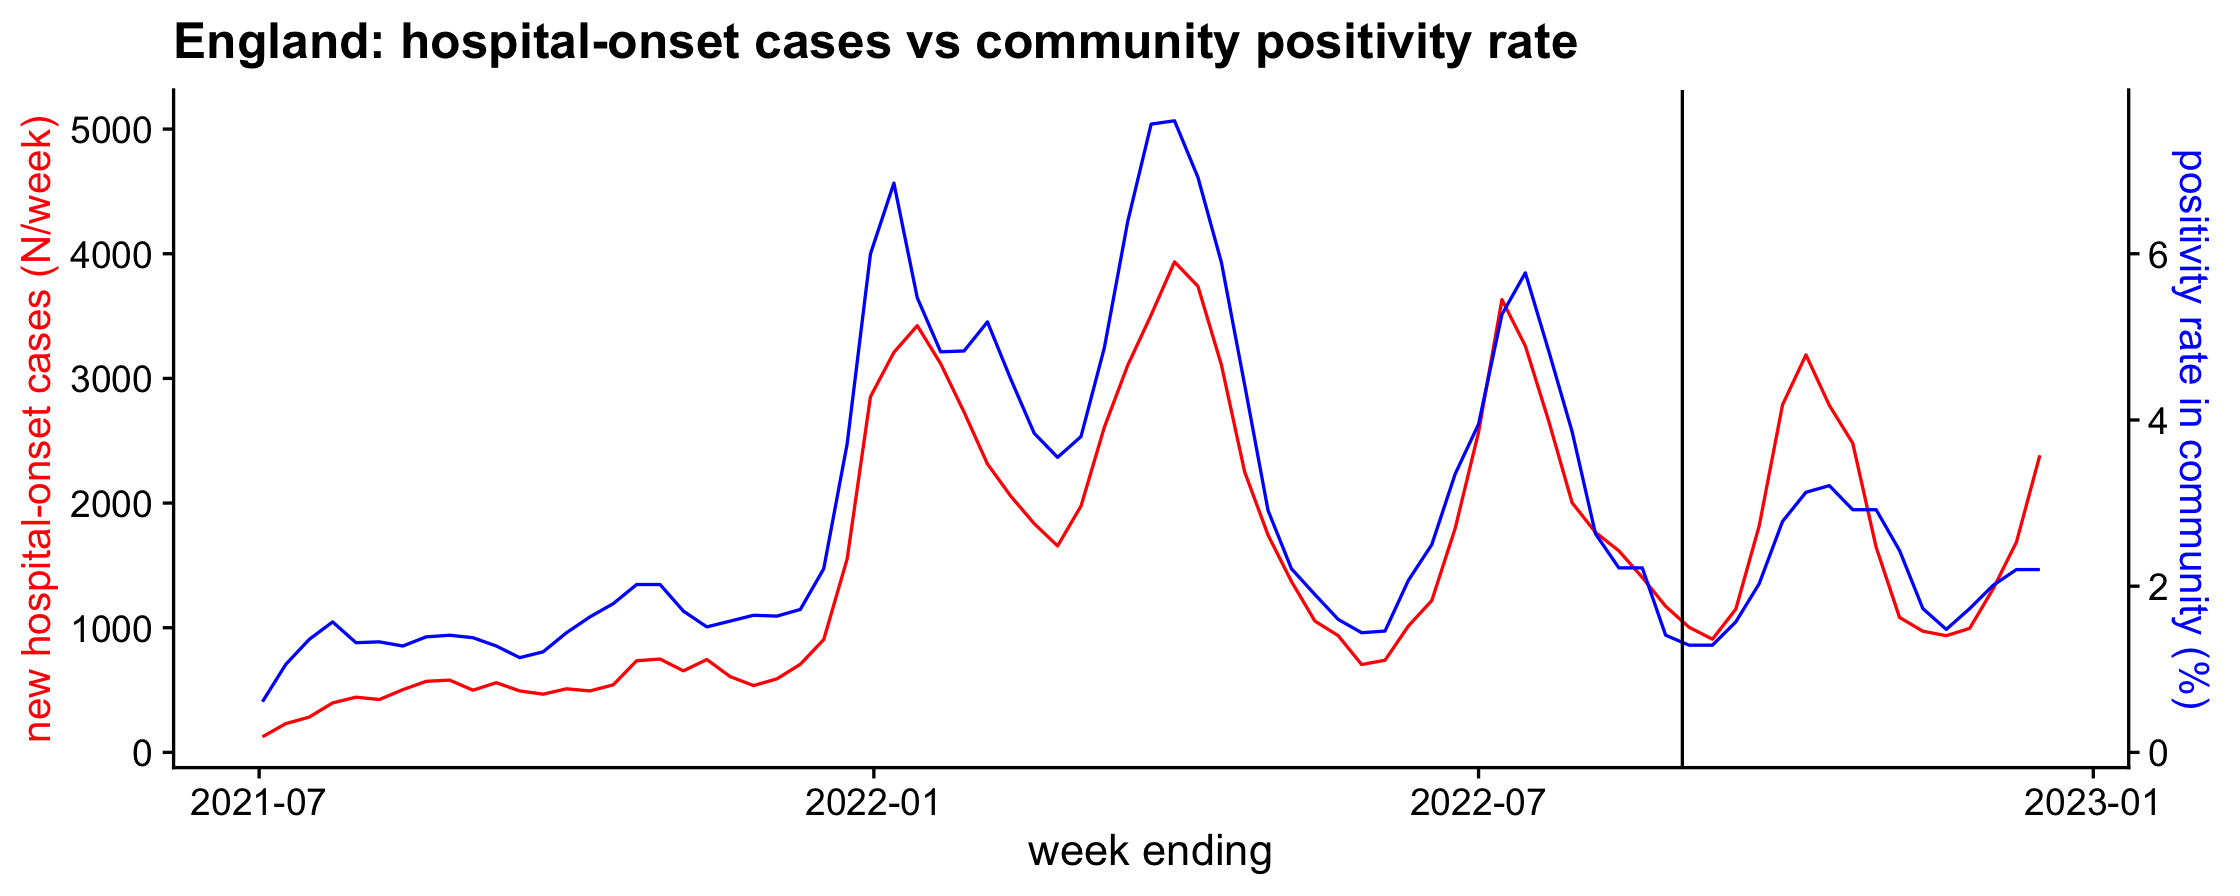

In [14]:
sec.axis.scaling <- 0.0015
options(repr.plot.width=10, repr.plot.height=4)
ggplot(dt.joined[date >= as.Date('2021-07-01'), ], aes(x=date)) +
    geom_line(aes(y = hospital_onset_adm_count), color = "red") +
    geom_line(aes(y = est_pct_positive / sec.axis.scaling), color = "blue") +
    geom_vline(xintercept = as.Date("2022-08-31"), linetype = "solid") +
    xlab("week ending") +
    scale_y_continuous(
        name = "new hospital-onset cases (N/week)",
        sec.axis = sec_axis(~ . * sec.axis.scaling, name = "positivity rate in community (%)")
    ) +
    ggtitle("England: hospital-onset cases vs community positivity rate") + 
    theme_cowplot() +
    theme(
        axis.title.y = element_text(color = "red", size=13),
        axis.title.y.right = element_text(color = "blue", size=13)
    )

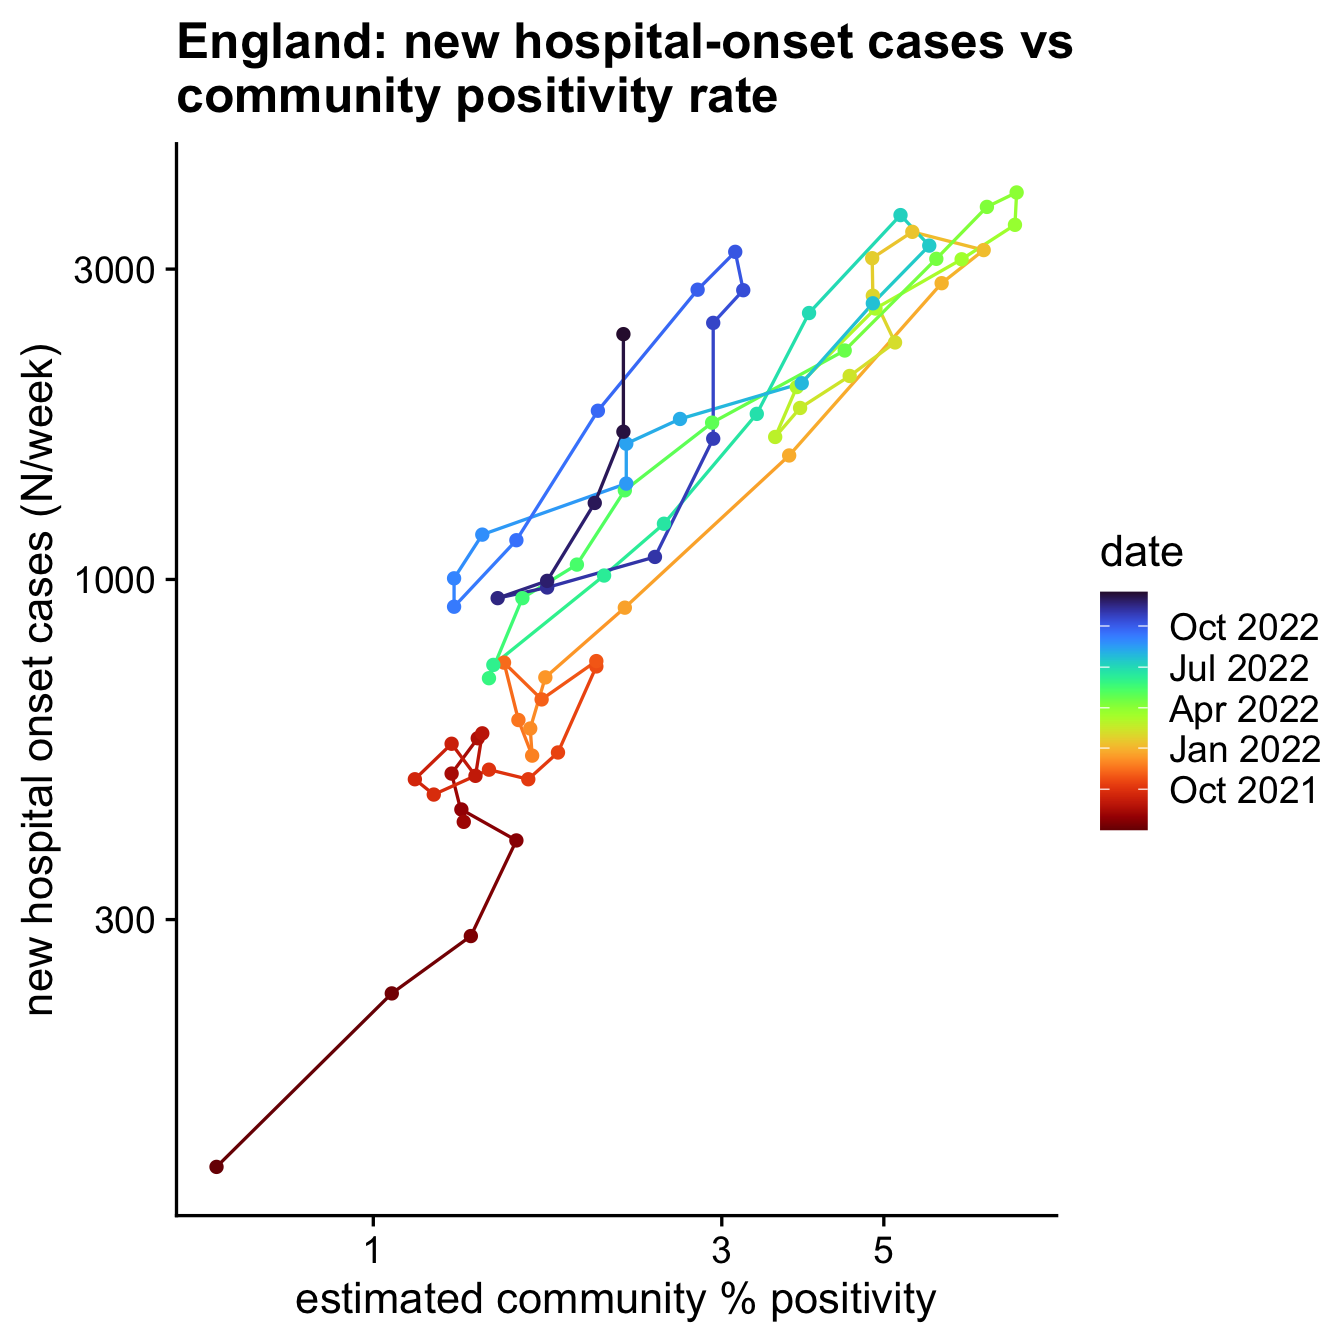

In [15]:
options(repr.plot.width=6, repr.plot.height=6)
ggplot(dt.joined[date >= as.Date('2021-07-01'), ], aes(x=est_pct_positive, y=hospital_onset_adm_count)) +
    geom_path(aes(color = date)) + geom_point(aes(color = date)) +
    scale_color_viridis(begin=1, end=0, option="turbo", trans = "date") +
    scale_x_log10() + scale_y_log10() +
    ggtitle("England: new hospital-onset cases vs \ncommunity positivity rate") + 
    xlab("estimated community % positivity") + ylab("new hospital onset cases (N/week)") +
    theme_cowplot()

Let's rework some of the above using absolute population counts for predicted community positivity

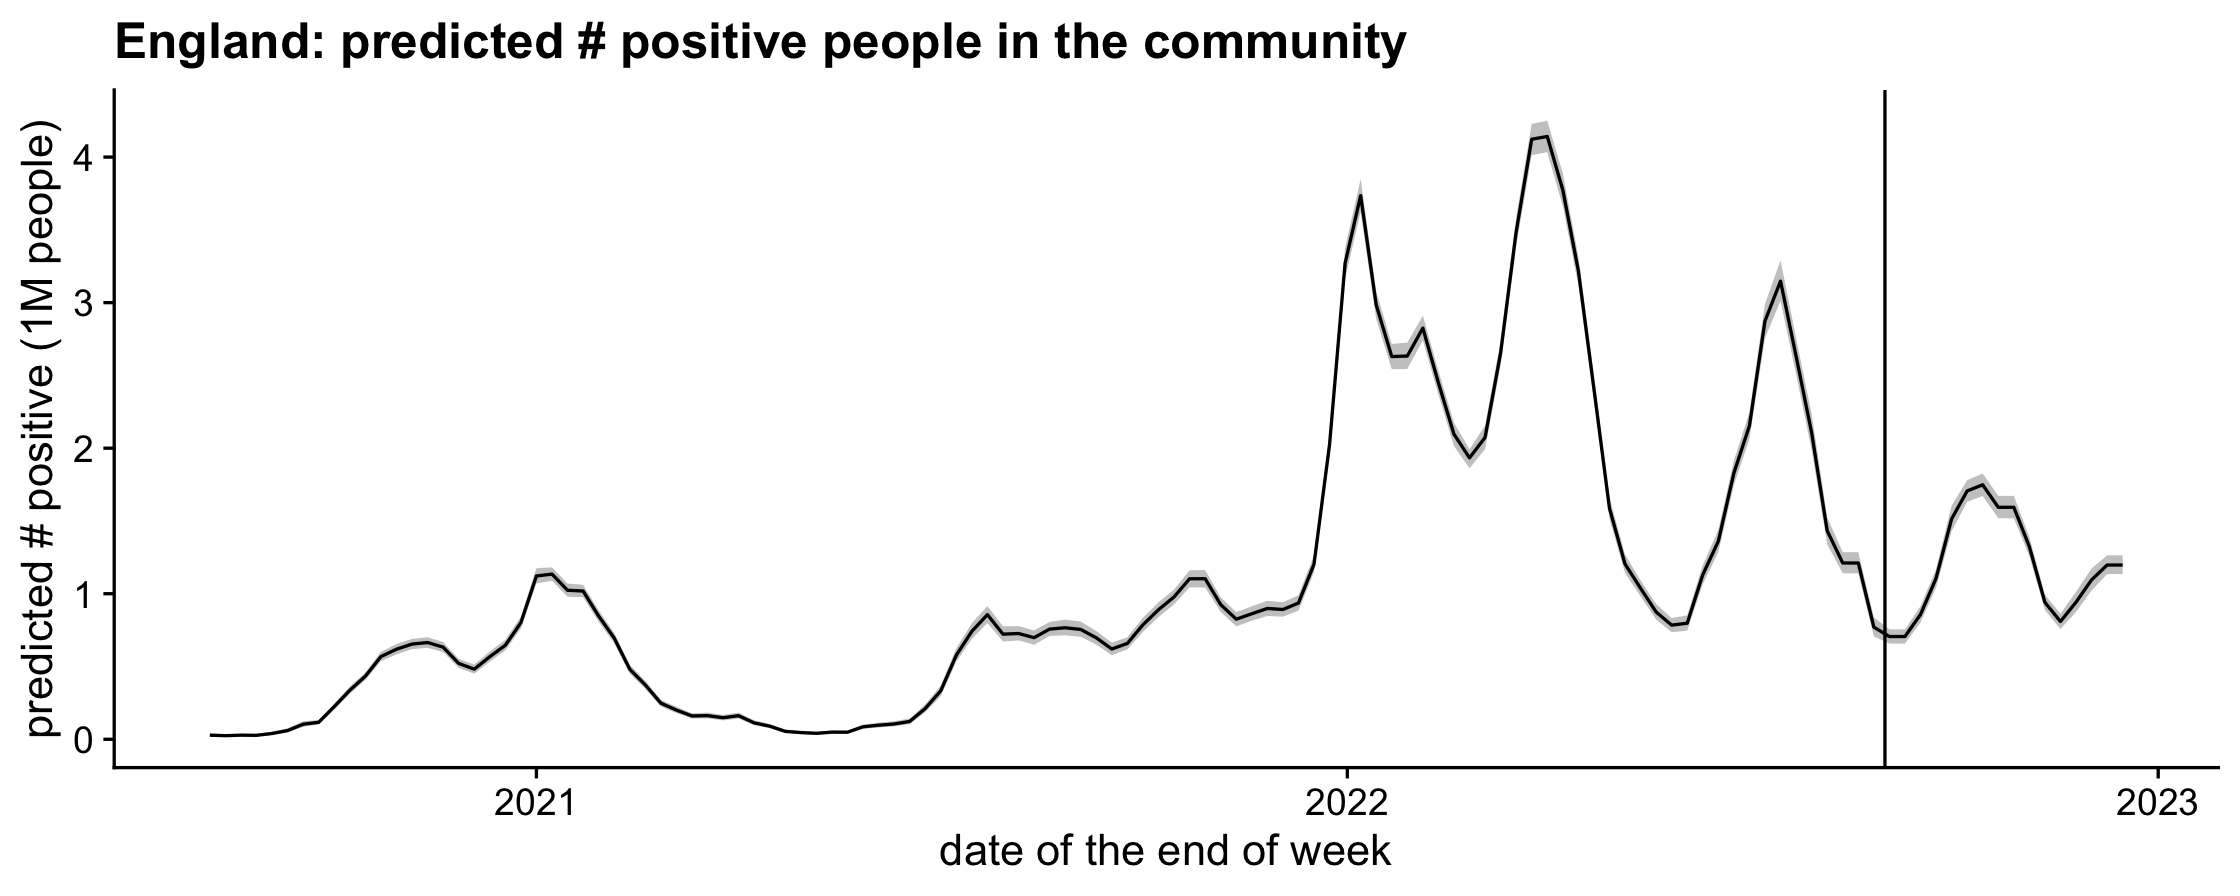

In [16]:
options(repr.plot.width=10, repr.plot.height=4)
ggplot(dt.joined, aes(x=date, y=est_pop_positive / 1e6)) +
    geom_ribbon(aes(ymin=est_pop_positive_ci95_lo / 1e6, ymax=est_pop_positive_ci95_hi / 1e6), alpha=0.3) +
    geom_line() + 
    geom_vline(xintercept = as.Date("2022-08-31"), linetype = "solid") +
    ylab("predicted # positive (1M people)") + xlab("date of the end of week") +
    ggtitle("England: predicted # positive people in the community") + 
    theme_cowplot()

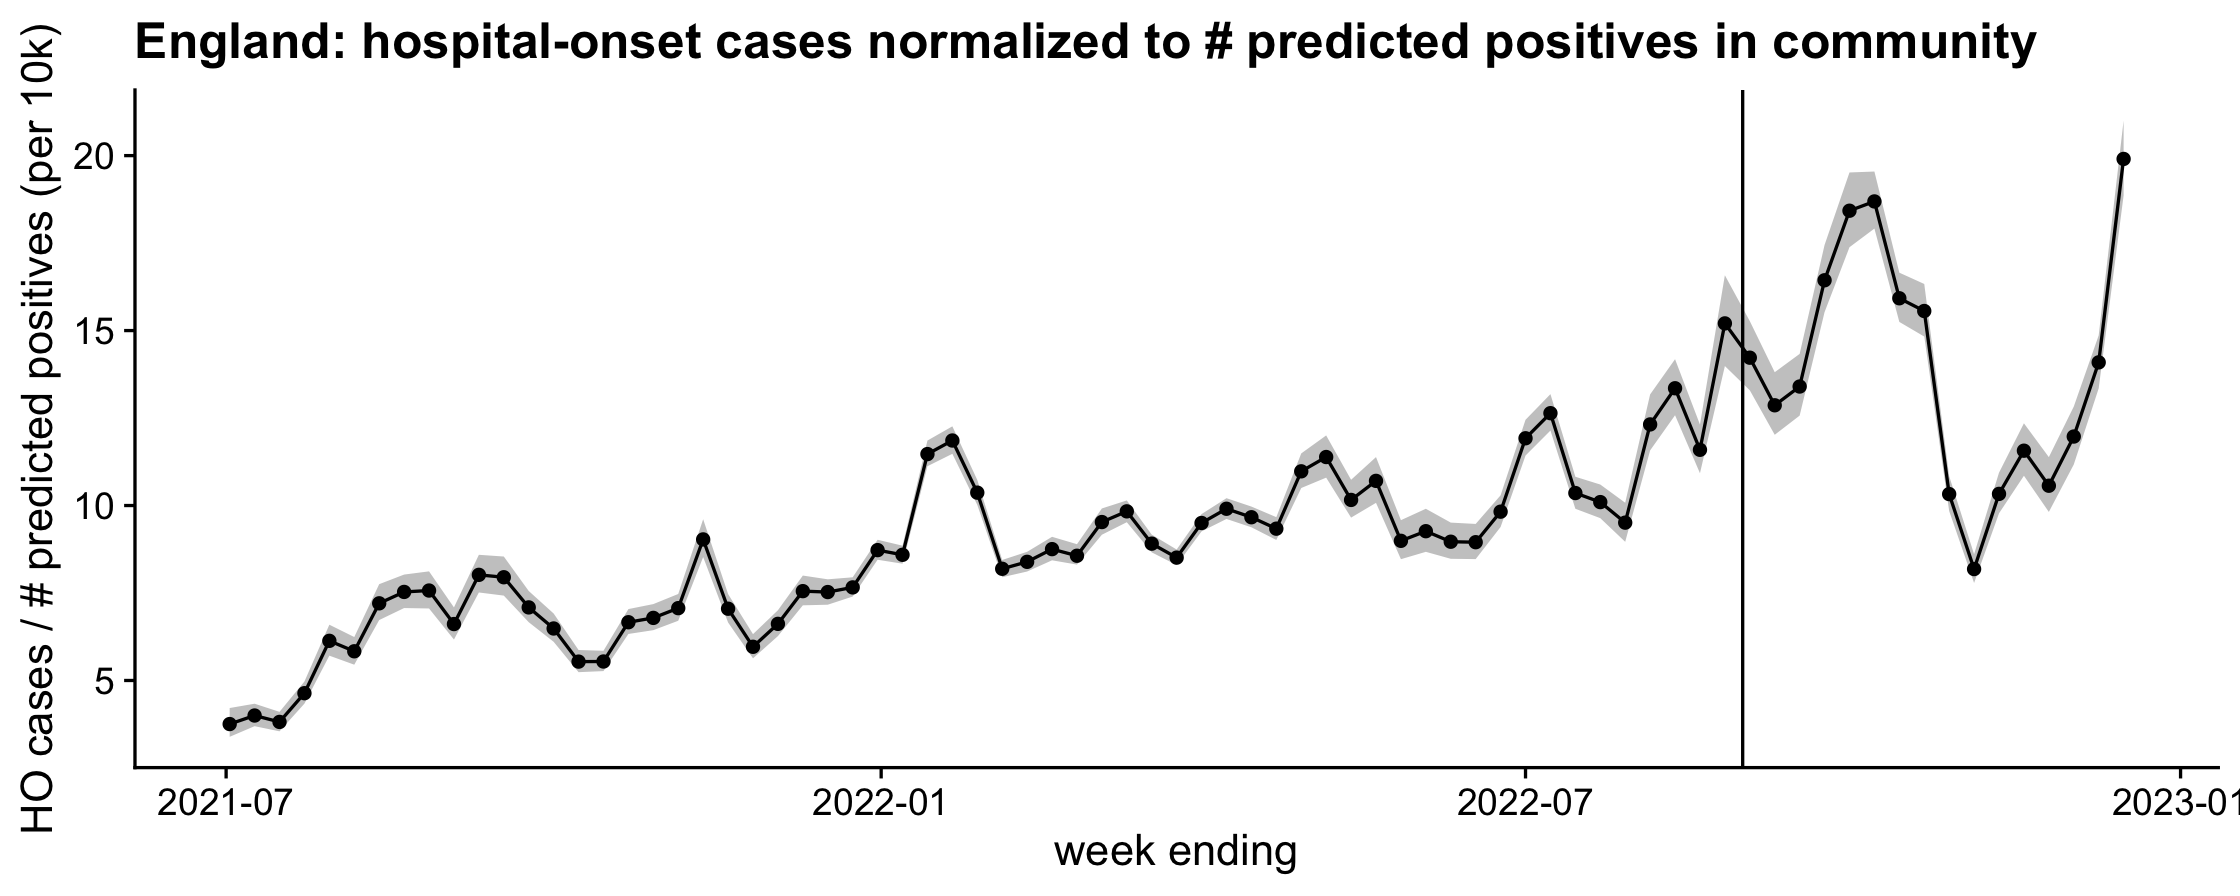

In [17]:
options(repr.plot.width=10, repr.plot.height=4)
ggplot(dt.joined[date >= as.Date('2021-07-01'), ], aes(x=date, y=hospital_onset_vs_comm_positives * 1e4)) +
    geom_ribbon(
        aes(
            ymin=hospital_onset_vs_comm_positives_ci95_lo * 1e4, 
            ymax=hospital_onset_vs_comm_positives_ci95_hi * 1e4
        ),
        alpha=0.3
    ) +
    geom_line() + geom_point() +
    geom_vline(xintercept = as.Date("2022-08-31"), linetype = "solid") +
    ylab("HO cases / # predicted positives (per 10k)") + xlab("week ending") +
    ggtitle("England: hospital-onset cases normalized to # predicted positives in community") + 
    theme_cowplot()

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


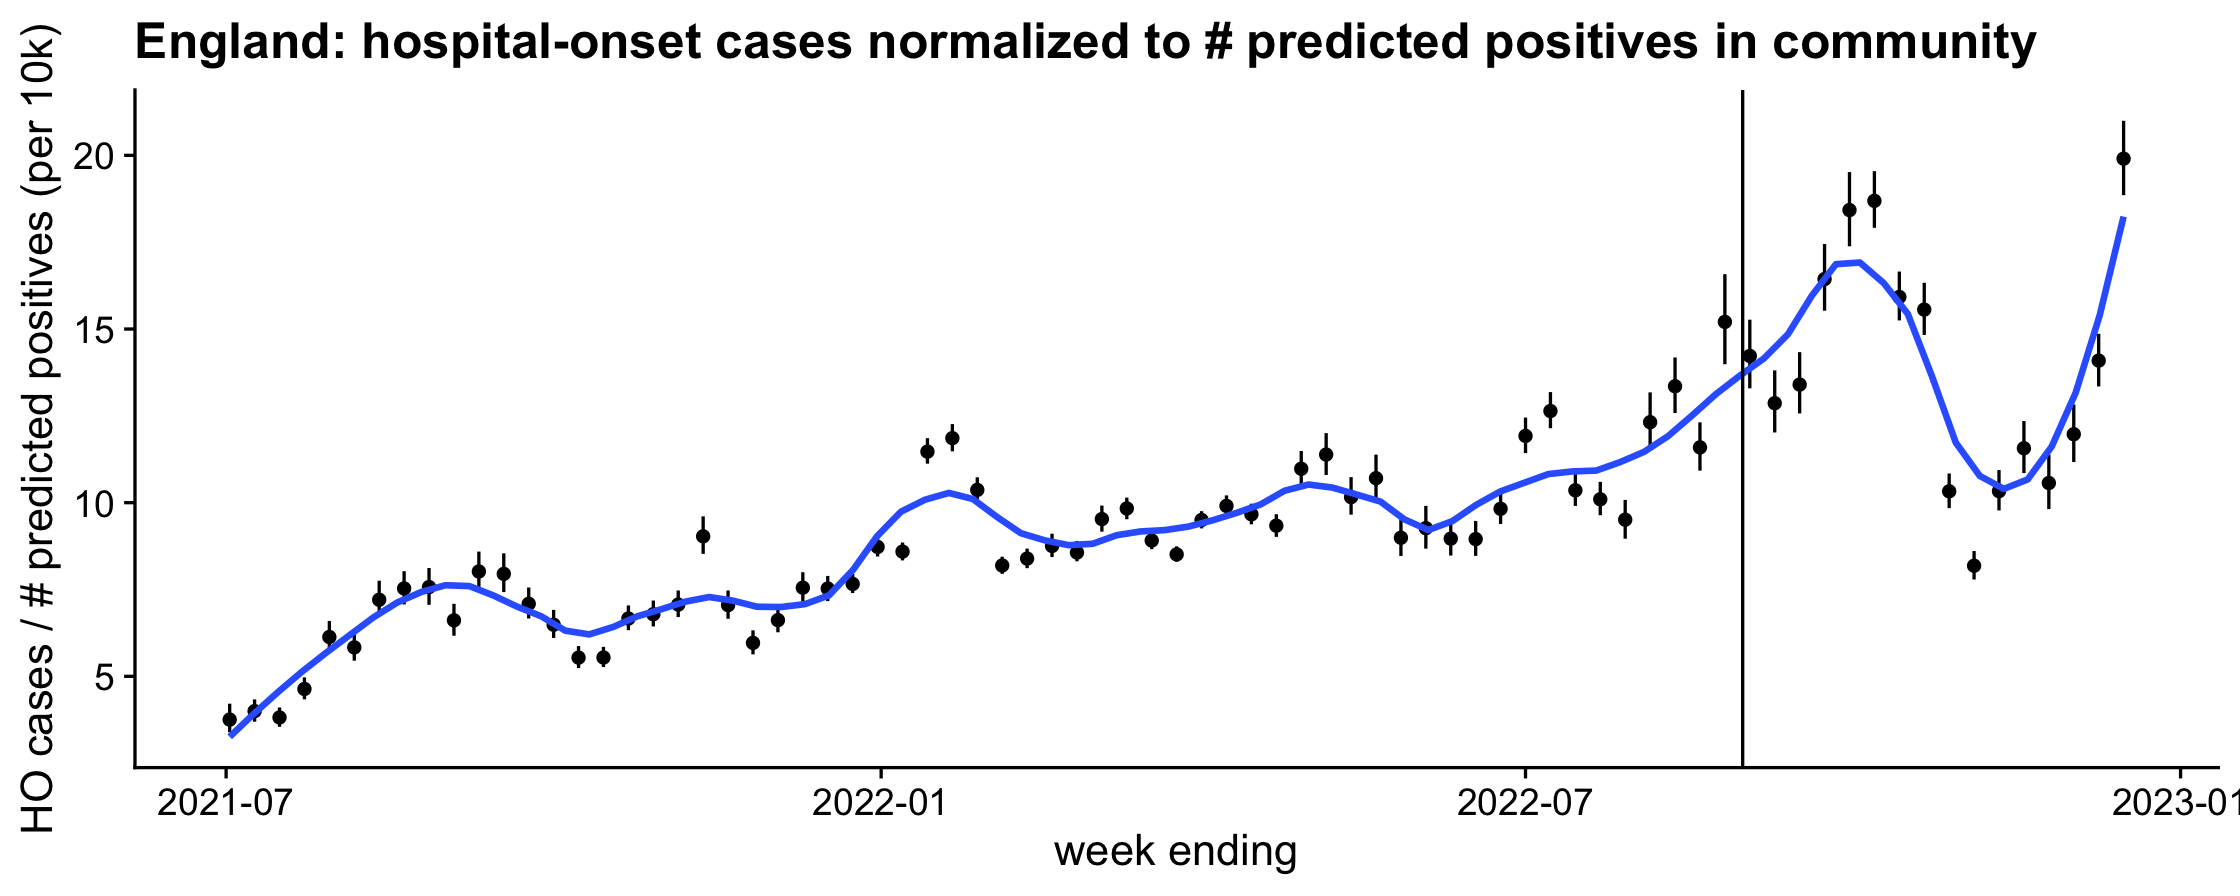

In [18]:
options(repr.plot.width=10, repr.plot.height=4)
ggplot(dt.joined[date >= as.Date('2021-07-01'), ], aes(x=date, y=hospital_onset_vs_comm_positives * 1e4)) +
    geom_point() +
    geom_errorbar(aes(
        ymin=hospital_onset_vs_comm_positives_ci95_lo * 1e4, 
        ymax=hospital_onset_vs_comm_positives_ci95_hi * 1e4,
        width=0
    )) +
    geom_smooth(se=FALSE, span=0.2) +
    geom_vline(xintercept = as.Date("2022-08-31"), linetype = "solid") +
    ylab("HO cases / # predicted positives (per 10k)") + xlab("week ending") +
    ggtitle("England: hospital-onset cases normalized to # predicted positives in community") + 
    theme_cowplot()

# save data; sessionInfo

> **Alec Trevelyan:** James, for England.
>
> **James Bond:** For England, Alec.

In [19]:
dt.joined[, region := "England"]
saveRDS(dt.joined, file="data/dt.england.rds")

In [20]:
sessionInfo()

R version 4.2.1 (2022-06-23)
Platform: aarch64-apple-darwin20 (64-bit)
Running under: macOS Monterey 12.5

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.2-arm64/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.2-arm64/Resources/lib/libRlapack.dylib

locale:
[1] C/UTF-8/C/C/C/C

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] lubridate_1.8.0   cowplot_1.1.1     yaml_2.3.5        viridis_0.6.2    
 [5] viridisLite_0.4.1 readxl_1.4.1      data.table_1.14.5 forcats_0.5.2    
 [9] stringr_1.4.1     dplyr_1.0.10      purrr_1.0.0       readr_2.1.3      
[13] tidyr_1.2.1       tibble_3.1.8      ggplot2_3.4.0     tidyverse_1.3.2  
[17] plyr_1.8.7       

loaded via a namespace (and not attached):
 [1] httr_1.4.4          jsonlite_1.8.0      splines_4.2.1      
 [4] modelr_0.1.9        assertthat_0.2.1    googlesheets4_1.0.1
 [7] cellranger_1.1.0    pill